# Using Lime with Pytorch

In this tutorial we will show how to use Lime framework with Pytorch. Specifically, we will use Lime to explain the prediction generated by one of the pretrained ImageNet models.

Let's start with importing our dependencies. This code is tested with Pytorch 1.0 but should work with older versions as well.

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
import pandas as pd
import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import pytorch_lightning as pl
from torch.nn import functional as F
from collections import defaultdict
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from torchvision import models
import torch.nn as nn
import os
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
from torchvision.models import ResNet18_Weights
import matplotlib.pyplot as plt
from torchvision import transforms
import json
import numpy as np
from tqdm import tqdm

Load our test image and see how it looks.

In [3]:
DATA_PATH = "./cassava"
CSV_FILE = "./cassava/cassava_split.csv"
IMAGES_PATH = "./cassava/images"
LABELS_FILE = "./cassava/label_num_to_disease_map.json"
print(CSV_FILE)

./cassava/cassava_split.csv


In [4]:
# Read split CSV + create a filepath column
cassava_df = pd.read_csv(CSV_FILE)
cassava_df["filepath"] = cassava_df.image_id.apply(lambda x: f"{IMAGES_PATH}/{x}")
cassava_df.head()

,image_id,label,set,filepath
0,1584105518.jpg,4,train,./cassava/images/1584105518.jpg
1,4020462779.jpg,1,train,./cassava/images/4020462779.jpg
2,3354881630.jpg,1,train,./cassava/images/3354881630.jpg
3,388811074.jpg,4,train,./cassava/images/388811074.jpg
4,4255258797.jpg,3,train,./cassava/images/4255258797.jpg


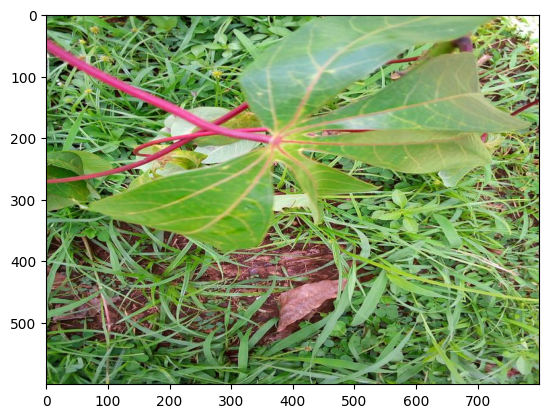

In [5]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image(cassava_df.iloc[0]["filepath"])
plt.imshow(img)

We need to convert this image to Pytorch tensor and also apply whitening as used by our pretrained model.

In [6]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [7]:
class CassavaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]

        x = Image.open(r.filepath).convert("RGB")
        y = torch.tensor(int(r.label), dtype=torch.long)

        if self.transform:
            x = self.transform(x)

        return x, y

In [8]:
class CassavaDataModule(pl.LightningDataModule):
    def __init__(self, df, bs=64, n_workers=2):
        super().__init__()

        self.df = df
        self.bs = bs
        self.n_workers = n_workers
        # Classes
        with open(LABELS_FILE, "r") as f:
            label_map = json.load(f)
        self.classes = list(label_map.values())

        # ImageNet1K validation transforms
        self.transform = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    def setup(self, stage: str):
        self.train_ds = CassavaDataset(
            self.df.query('set == "train"'), transform=self.transform
        )
        self.val_ds = CassavaDataset(
            self.df.query('set == "val"'), transform=self.transform
        )
        self.test_ds = CassavaDataset(
            self.df.query('set == "test"'), transform=self.transform
        )

    def train_dataloader(self):
        dataloader = DataLoader(
            self.train_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=True
        )
        return tqdm(dataloader, desc="Training", leave=False)

    def val_dataloader(self):
        dataloader = DataLoader(
            self.val_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=False
        )
        return tqdm(dataloader, desc="Validation", leave=False)

    def test_dataloader(self):
        dataloader = DataLoader(
            self.test_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=False
        )
        return tqdm(dataloader, desc="Testing", leave=False)

In [ ]:
dm = CassavaDataModule(cassava_df, bs=64, n_workers=1)
dm.setup(None)
x, y = next(iter(dm.train_dataloader()))
x.shape, y.shape

Training:   0%|          | 0/235 [00:00<?, ?it/s]

In [ ]:
class LightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, wd=0.0, discriminative_lr=None):
        super().__init__()
        self.model = model
        self.lr = lr
        self.wd = wd
        self.discriminative_lr = discriminative_lr  # (lr, lr_mult)

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)

    def get_layer_wise_lr(self, lr, lr_mult):
        # Save layer names
        layer_names = []
        for idx, (name, param) in enumerate(self.model.named_parameters()):
            layer_names.append(name)
            print(f"{idx}: {name}")

        # Reverse layers
        layer_names.reverse()

        # placeholder
        parameters = []
        prev_group_name = layer_names[0].split(".")[0]

        # store params & learning rates
        for idx, name in enumerate(layer_names):
            # parameter group name
            cur_group_name = name.split(".")[0]

            # update learning rate
            if cur_group_name != prev_group_name:
                lr *= lr_mult
            prev_group_name = cur_group_name

            # display info
            print("Using discriminative learning rates")
            print(f"{idx}: lr = {lr:.6f}, {name}")

            # append layer parameters
            parameters += [
                {
                    "params": [
                        p
                        for n, p in self.model.named_parameters()
                        if n == name and p.requires_grad
                    ],
                    "lr": lr,
                }
            ]

        return parameters

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters()
            if self.discriminative_lr == None
            else self.get_layer_wise_lr(*self.discriminative_lr),
            lr=self.lr,
            weight_decay=self.wd,
        )

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True)

        self.training_step_outputs["loss"] += loss.detach().cpu()
        self.training_step_outputs["steps"] += 1

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)

        self.validation_step_outputs["loss"] += loss.detach().cpu()
        self.validation_step_outputs["steps"] += 1

        return loss

    def on_train_epoch_end(self):
        avg_loss = (
            self.training_step_outputs["loss"] / self.training_step_outputs["steps"]
        )
        print(
            f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}"
        )
        self.training_step_outputs.clear()

    def on_validation_epoch_end(self):
        avg_loss = (
            self.validation_step_outputs["loss"] / self.validation_step_outputs["steps"]
        )
        print(
            f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}"
        )
        self.validation_step_outputs.clear()

In [ ]:
pl.seed_everything(seed=42, workers=True)

weights = ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 5)

lightning_module = LightningModule(model, discriminative_lr=(1e-3, 0.9))

csv_logger = CSVLogger(save_dir=os.getcwd(), name="cassava_ft_disc_lr")

model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    filename="best_valid_loss",
    verbose=True,
    save_last=False,
)

trainer = pl.Trainer(
    max_epochs=5, logger=csv_logger, callbacks=[model_checkpoint_callback]
)

data_module = CassavaDataModule(df=cassava_df, bs=64, n_workers=8)

trainer.fit(lightning_module, data_module)

Seed set to 42


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

Load the pretrained model for Resnet50 available in Pytorch.

Load label texts for ImageNet predictions so we know what model is predicting

In [ ]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath(LABELS_FILE), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}    

Get the predicition for our image.

In [ ]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

Predicitions we got are logits. Let's pass that through softmax to get probabilities and class labels for top 5 predictions.

In [ ]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

We are getting ready to use Lime. Lime produces the array of images from original input image by pertubation algorithm. So we need to provide two things: (1) original image as numpy array (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output. 

For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.

In [ ]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Now we are ready to define classification function that Lime needs. The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). The output is numpy aaray of shape (image index, classes) where each value in array should be probability for that image, class combination.

In [ ]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Let's test our function for the sample image.

In [ ]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

In [ ]:
model = LightningModule.load_from_checkpoint(
    model_checkpoint_callback.best_model_path, model=model
)
model.cuda(0)

y_trues, y_hats = [], []

for x, y_true in iter(data_module.test_dataloader()):
    with torch.no_grad():
        y_hat_logits = model(x.cuda())
        y_hat = nn.Softmax(1)(y_hat_logits).argmax(1)
        y_hat = y_hat.detach().cpu()

    y_hats.append(y_hat)
    y_trues.append(y_true)

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries

short_names = ["CBB", "CBSD", "CGM", "CMD", "Healthy"]

def display_all_classes_one_plot(data_module, y_trues, y_hats, num_images=5):
    """
    Create ONE single plot containing all classes.
    For each class → 5 correct examples (top row) + 5 misclassified (bottom row).
    Total rows = 2 × num_classes.
    """
    
    # Prepare dataset and explainer
    dataset = data_module.test_dataloader().dataset
    explainer = lime_image.LimeImageExplainer()

    num_classes = len(short_names)
    rows = num_classes * 2
    cols = num_images

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 2.2))
    fig.suptitle(
        "LIME Explanations – Correct (Row 1 per class) vs Misclassified (Row 2 per class)",
        fontsize=20,
        y=1.02
    )

    # Ensure axes always 2D
    if rows == 1:
        axes = axes.reshape(1, -1)

    for class_id in range(num_classes):

        # Rows for this class
        row_correct = class_id * 2
        row_miscls  = class_id * 2 + 1

        class_name = short_names[class_id]

        # Find indices
        correct_idx = ((y_trues == class_id) & (y_hats == class_id)).nonzero(as_tuple=True)[0][:num_images]
        miscls_idx = ((y_trues == class_id) & (y_hats != class_id)).nonzero(as_tuple=True)[0][:num_images]

        # -------- Correct examples --------
        for i in range(cols):
            ax = axes[row_correct, i]

            if i < len(correct_idx):
                idx = correct_idx[i]
                img_path = dataset.samples[idx][0]
                img = get_image(img_path)

                explanation = explainer.explain_instance(
                    np.array(pill_transf(img)),
                    batch_predict,
                    top_labels=1,
                    hide_color=0,
                    num_samples=1000
                )

                temp, mask = explanation.get_image_and_mask(
                    explanation.top_labels[0],
                    positive_only=True,
                    num_features=5,
                    hide_rest=False
                )

                img_ready = mark_boundaries(temp / 255.0, mask)
                ax.imshow(img_ready)
                ax.set_title(f"{class_name} (Correct)", color="green", fontsize=9)
            else:
                ax.axis("off")

            ax.axis("off")

        # -------- Misclassified examples --------
        for i in range(cols):
            ax = axes[row_miscls, i]

            if i < len(miscls_idx):
                idx = miscls_idx[i]
                img_path = dataset.samples[idx][0]
                img = get_image(img_path)

                true_label = y_trues[idx].item()
                pred_label = y_hats[idx].item()

                explanation = explainer.explain_instance(
                    np.array(pill_transf(img)),
                    batch_predict,
                    top_labels=1,
                    hide_color=0,
                    num_samples=1000
                )

                temp, mask = explanation.get_image_and_mask(
                    explanation.top_labels[0],
                    positive_only=True,
                    num_features=5,
                    hide_rest=False
                )

                img_ready = mark_boundaries(temp / 255.0, mask)
                ax.imshow(img_ready)
                ax.set_title(
                    f"True: {short_names[true_label]}\nPred: {short_names[pred_label]}",
                    color="red",
                    fontsize=9,
                )
            else:
                ax.axis("off")

            ax.axis("off")

        # Label class rows on the left
        axes[row_correct, 0].set_ylabel(f"{class_name}\nCorrect", fontsize=12)
        axes[row_miscls, 0].set_ylabel(f"{class_name}\nMiscls", fontsize=12)

    plt.tight_layout()
    plt.show()


In [ ]:

# --- Short class names ---
short_names = ["CBB", "CBSD", "CGM", "CMD", "Healthy"]


def display_examples_from_module(data_module, y_trues, y_hats, num_images=10):
    """
    Display correctly classified and misclassified images per class from a LightningDataModule
    Only for CBB and CGM
    """
    # Indices
    correct_idx = (y_trues == y_hats).nonzero(as_tuple=True)[0]
    misclassified_idx = (y_trues != y_hats).nonzero(as_tuple=True)[0]

    dataset = data_module.test_dataloader().dataset
    explainer = lime_image.LimeImageExplainer()

    # Only display CBB (0) and CGM (2)
    for class_id in [0, 2]:
        class_name = short_names[class_id]

        # Filter indices for this class
        correct_class_idx = correct_idx[y_trues[correct_idx] == class_id][:num_images]
        misclassified_class_idx = misclassified_idx[
            y_trues[misclassified_idx] == class_id
        ][:num_images]

        total_rows = 2
        total_cols = num_images
        fig, axes = plt.subplots(total_rows, total_cols, figsize=(2.5 * total_cols, 5))
        fig.suptitle(
            f"Class: {class_name}\nTop: Correct | Bottom: Misclassified",
            fontsize=16,
            y=1.05,
        )

        if total_cols == 1:
            axes = axes.reshape(2, 1)

        # Correctly classified
        for i, idx in enumerate(correct_class_idx):
            img = get_image(cassava_df.iloc[int(idx)]["filepath"])
            explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
            img_boundry1 = mark_boundaries(temp/255.0, mask)
            axes[0, i].imshow(img_boundry1)
            pred_label = y_hats[idx].item()
            axes[0, i].set_title(
                f"Pred: {short_names[pred_label]}", color="green", fontsize=9
            )
            axes[0, i].axis("off")

        for j in range(len(correct_class_idx), total_cols):
            axes[0, j].axis("off")

        # Misclassified
        for i, idx in enumerate(misclassified_class_idx):
            img, true_label = get_image(cassava_df.iloc[int(idx)]["filepath"]), cassava_df.iloc[int(idx)]["label"]
            explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
            img_boundry1 = mark_boundaries(temp/255.0, mask)
            axes[1, i].imshow(img_boundry1)
            pred_label = y_hats[idx].item()
            axes[1, i].set_title(
                f"True: {short_names[int(true_label)]}\nPred: {short_names[int(pred_label)]}",
                color="red",
                fontsize=9,
            )
            axes[1, i].axis("off")

        for j in range(len(misclassified_class_idx), total_cols):
            axes[1, j].axis("off")

        plt.subplots_adjust(wspace=0.1, hspace=0.25, top=0.8)
        plt.show()


# --- Example usage ---
display_examples_from_module(dm, y_trues, y_hats, num_images=5)

Import lime and create explanation for this prediciton.

In [ ]:
from lime import lime_image

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

Let's use mask on image and see the areas that are encouraging the top prediction.

In [ ]:
from skimage.segmentation import mark_boundaries

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

Let's turn on areas that contributes against the top prediction.

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)